<center>
<h1>
Analyzing the Sentiment of Online Substance Abuse Support Groups During the
COVID-19 Pandemic via Natural Language Processing
</h1>
<h5>
By <a href="https://zeyadmansour.com">Zeyad Mansour</a> 
</h5>
<h5> 
<a href="https://www.google.com">Read the paper</a>
</h5>
</center>

# 1 Scraping / Data Collection

## 1.1 Installing dependencies and importing those for scraping

<p> Although not shown here, it is recommended that the following packages are installed in a conda virtual environment. The jupyter kernel also must be installed in the environment. </p>

In [1]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/cu113


<hr>

**PRAW (the Python Reddit API Wrapper)** allows us to obtain the current "score" of a post, which is the total number of upvotes minus the total number of downvotes. PRAW can be used in conjunction with PSAW, which lacks this functionality.

**PSAW (the Python PushShift API Wrapper)** allows us to obtain historical posts, whereas PRAW does not have this functionality. PushShift is a third-party service that scrapes Reddit to provide "enhanced functionality and search capabilities for searching Reddit comments and submissions." Their API is intended research purposes. Because PushShift scrapes posts only once — shortly after they are posted — the reported score is only accurate at the time they were scraped.

In [2]:
from calendar import monthrange
from collections import Counter

# the datetime object allows for easy chronological organization of the dataframe 
from datetime import datetime
import json

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import os

# the data retrieved from the API is stored in a pandas dataframe
import pandas as pd

# python wrapper for the official reddit api
import praw 

# python wrapper for the pushshift api
from psaw import PushshiftAPI 

import random
import statistics
import sys
import time

[nltk_data] Downloading package stopwords to /home/zeyad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeyad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.2 Authenticating with the Reddit API 

In order to use the Reddit API, an account must be granted access. After agreeing to follow the ToS, a Reddit user can apply [here](https://docs.google.com/forms/d/e/1FAIpQLSezNdDNK1-P8mspSbmtC2r86Ee9ZRbC66u929cG2GX0T9UMyw/viewform).


Then, we can authenticate with PRAW with the credentials that we provide in the [client_secrets.json](client_secrets.jsonclient_secrets.jsonclient_secrets.json) file.

In [3]:
# client_secrets.json file must be created to contain credentials
# ex_client_secrets.json contains the example credentials format
f = open('client_secrets.json') 
 
client_secrets = json.load(f)

r = praw.Reddit(client_id=client_secrets["client_id"],
    client_secret=client_secrets["client_secret"],
    username=client_secrets["username"],
    password=client_secrets["password"],
    user_agent=client_secrets["user_agent"]
)

api = PushshiftAPI(r)

## 1.3 Scraping via Requests to the API 

We define a list of the subreddits that we want to scrape and initialize the appropriate time interval variables.

In [4]:
subreddits = ["addiction", "alcoholism", "benzorecovery", "leaves", "OpiatesRecovery", "quittingkratom", 
              "QuittingPhenibut", "redditorsinrecovery",  "StopDrinking", "StopSmoking", "StopSpeeding"]  
start_year = 2019
start_month = 10
end_year = 2022
end_month = 2

The following cell contains helper functions for future steps.

In [5]:
def save_posts_by_month(subreddit, year, month, limit=100000):
    ''' 
    Scrapes and saves all posts from the specified subreddit to a CSV file
    given a particular month in the "year-month" format
    '''
    num_days = monthrange(year, month)[1]
    after=int(datetime(year, month, 1).timestamp())
    before=int(datetime(year, month, num_days).timestamp()) 
    print(f"Scraping posts from /r/{subreddit} [{year}, {month}]...")
    gen = api.search_submissions(after=after, before=before, subreddit=subreddit, limit=limit)
    post_list = []
    for e in gen:
        submission = r.submission(e)
        post_list.append({"Date": datetime.fromtimestamp(submission.created_utc), "URL": submission.url, "Title": submission.title, "Body": submission.selftext, "Score": submission.score})
        
    df = pd.DataFrame(post_list)
    df.to_csv(f"data/{subreddit}/{subreddit}_{year}-{month}.csv", index = False, header = True)
    
def iter_months(start_year, start_month, end_year, end_month):
    ''' 
    Yields the dates of months in the "year-month" format given time interval 
    '''   
    while (start_year == end_year and start_month <= end_month) or (start_year < end_year):
        if start_month < 12:
            yield {"year":start_year, "month":start_month}
            start_month += 1
        else:
            yield {"year":start_year, "month":start_month}
            start_year += 1
            start_month = 1

We want to be able to permanently store the data that we scrape for future analysis. 

The scraping process can be lengthly due to rate limiting, and storing the data we get from the API in memory is bad practice when considering the likelihood of a crash. Therefore, for each subreddit, after each month of posts we scrape, we save the pandas dataframe to the disk (in the .csv file format).

In [6]:
def scrape_posts(subreddits, start_year, start_month, end_year, end_month):
    print(f"{len(subreddits)} subreddits selected")

    datadir = 'data'
    try:
        os.mkdir('data')
        print(f"Directory '{datadir}' was created") 
    except FileExistsError:
        print(f"Directory '{datadir}' already exists")
        
    for subreddit in subreddits:
        datadir = f"data/{subreddit}"
        try:
            os.mkdir(datadir)
            print(f"Directory '{datadir}' was created") 
        except FileExistsError:
            print(f"Directory '{datadir}' already exists")
            continue
            
        for date in iter_months(start_year, start_month, end_year, end_month):
            save_posts_by_month(subreddit, date["year"], date["month"])
       

scrape_posts(subreddits, start_year, start_month, end_year, end_month)

11 subreddits selected
Directory 'data' already exists
Directory 'data/addiction' already exists
Directory 'data/alcoholism' already exists
Directory 'data/benzorecovery' already exists
Directory 'data/leaves' already exists
Directory 'data/OpiatesRecovery' already exists
Directory 'data/quittingkratom' already exists
Directory 'data/QuittingPhenibut' already exists
Directory 'data/redditorsinrecovery' already exists
Directory 'data/StopDrinking' already exists
Directory 'data/StopSmoking' already exists
Directory 'data/StopSpeeding' already exists


## 1.4 Data Preprocessing and Downsampling

Posts that were deleted, or contain little to no data, are still part of our data. We want to remove these from our dataset. To do this, we search each post for the keywords "deleted" or "removed" and remove those posts.

In [7]:
#Delete the posts that were either deleted or removed
deleted_keywords = ["deleted", "removed"]

for subreddit in subreddits: 
    for date in iter_months(start_year, start_month, end_year, end_month): 
        filename = f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv'
        indicies_to_delete = list()
        df = pd.read_csv(filename) 
        for index, row in df.iterrows():
            for e in deleted_keywords:
                if e in str(row["Title"]) or e in str(row["Body"]):
                    indicies_to_delete.append(index)
                    
        df = df.drop(labels=indicies_to_delete, axis=0)
        df = df.reset_index()
        df = df.drop(labels="index", axis=1)
        df.to_csv(filename, index=False)

print("Finished removing the posts that were either deleted or removed.")

Finished removing the posts that were either deleted or removed.


Now, we have our data stored via .csv files. We can then load this in a pandas dataframe to look at the data collected over the course of one month for a subreddit.

In [8]:
filename = f'data/{subreddits[0]}/{subreddits[0]}_{start_year}-{start_month}.csv'
df = pd.read_csv(filename) 
print(filename)
display(df)

data/addiction/addiction_2019-10.csv


,Date,URL,Title,Body,Score
0,2019-10-30 22:35:14,https://www.reddit.com/r/addiction/comments/dp...,I'm committed to making a change...,Last week I came out to my wife and shared wit...,5
1,2019-10-30 22:16:46,https://www.reddit.com/r/addiction/comments/dp...,"If I could use successfully forever, I would",I didn’t quit because it was the right thing t...,1
2,2019-10-30 19:04:33,https://www.reddit.com/r/addiction/comments/dp...,I'm wondering if it's a bad idea for an alcoho...,NaN,2
3,2019-10-30 18:35:13,https://www.reddit.com/r/addiction/comments/dp...,Septum Hole Question,Throwaway. Could really use some help here.\n\...,1
4,2019-10-30 14:57:27,https://www.reddit.com/r/addiction/comments/dp...,My sister (13) is using drugs,"It says it in the title, my sister is getting ...",1
...,...,...,...,...,...
277,2019-10-01 09:39:39,https://www.reddit.com/r/addiction/comments/db...,Day 2 sober,Yesterday was my first day sober in years I fe...,4
278,2019-10-01 09:00:43,https://www.reddit.com/r/addiction/comments/db...,Leading to a habit or just being a pig ?,Last few months I’ve been hitting speed or mdm...,2
279,2019-10-01 06:14:51,https://www.reddit.com/r/addiction/comments/db...,110 days sober until today,Stress. Idk what to say. Thought I had it this...,11
280,2019-10-01 02:16:04,https://www.reddit.com/r/cocaine/comments/dbmn...,Today I shot up WAY too much cocaine and I got...,NaN,2


<hr>

# 2 Trend Analysis

Here, we do some exploratory analysis.

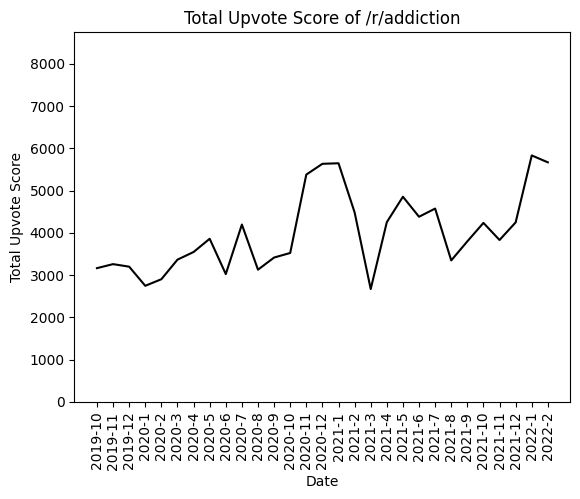

In [9]:
plt.style.use('default')

#Only plot one subreddit since this is for demonstration
for subreddit in ["addiction"]: 
    dates = list()
    scores_stat = list()
    for date in iter_months(start_year, start_month, end_year, end_month): 
        score_list = list()
        df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
        for index, row in df.iterrows():
            score_list.append(row["Score"])
        scores_stat.append(sum(score_list))
        dates.append(f'{date["year"]}-{date["month"]}')             
    x = dates
    y = scores_stat
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Total Upvote Score')
    plt.title(f'Total Upvote Score of /r/{subreddit}')
    plt.ylim(ymin=0, ymax = max(y)*1.5)
    plt.plot(x, y, color='black');
    plt.show()

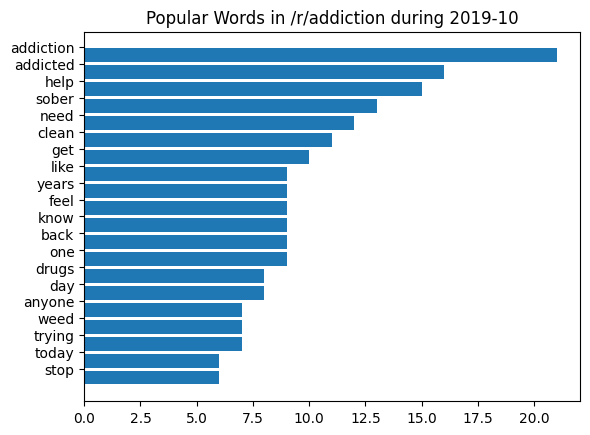

In [10]:
stopwords_set = stopwords.words('english')

def wordBarGraph(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords_set and w.isalnum()]
    plt.barh(range(20), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:20])])
    plt.yticks([x + 0.5 for x in range(20)], reversed(popular_words_nonstop[0:20]))
    plt.title(title)
    plt.show()
    
#Only plot one subreddit since this is for demonstration    
for subreddit in ["addiction"]: 
    #Only plot one month since this is for demonstration
    for date in iter_months(start_year, start_month, start_year, start_month): 
        df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
        plt.figure()
        wordBarGraph(df,'Title',f"Popular Words in /r/{subreddit} during {date['year']}-{date['month']}")

We define a list of COVID-19 related tokens to see how mention of COVID-19 has varied overtime.

In [11]:
#TODO

<hr>

# 3 Sentiment Analysis and Classification

Transformer models, such as GPT-3 and BERT, have revolutionalized today's NLP landscape. They have built upon the original transformer model, which performed sequence-to-sequence tasks, and are now capable of performing a wide variety of language tasks, such as text summarization and machine translation.

However, while being very capable, they come with one major drawback: their size. The size of models such as BERT significantly limits their adoption because they require massive computational resources train or even perform inference.

In attempt to lessen this problem, in 2019, researchers released [DistilBERT](https://arxiv.org/abs/1910.01108), which is a modified version of the [BERT](https://arxiv.org/abs/1810.04805) NLP model. DistilBERT applies parameter-reduction techniques in order to lower memory consumption and increase the training speed of BERT. This implies decreased GPU/TPU memory requirements and training times. Compared to the 110 million parameters of BERT-base model, the DistilBERT-base-uncased model has only 66 million parameters while using half the layers (6) the same number of hidden units (768).

HuggingFace's `transformers` library provides an easy way to download state-of-the-art pretrained models. For our purpose, we load DistilBERT using the "sentiment-analysis" pipeline provided by this library.

## 3.1 Loading ALBERT

In this case, we set the `TRANSFORMERS_CACHE` environment variable before importing `transformers` because we prefer the model to download to a local folder.

In [12]:
import os

os.environ['TRANSFORMERS_CACHE'] = 'transformers_cache/' 

import torch

if torch.cuda.is_available():
    device = 0
else:
    device = -1
    print("PyTorch is unable to access CUDA installation.")
    
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer

pipe = pipeline(task="sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", device = device)

In [14]:
def data():
    for subreddit in subreddits: 
        dates = list()
        for date in iter_months(start_year, start_month, end_year, end_month): 
            score_list = list()
            df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
            for index, row in df.iterrows():
                yield f'{row["Title"]}. {row["Body"]}'
                time.sleep(1)

data_gen = data()
for e in data_gen:
    try:
        results_dict = pipe(e)
        print(pipe(e))
        print(e)
    except RuntimeError:
        print("Too long")


[{'label': 'POSITIVE', 'score': 0.9977933168411255}]
I'm committed to making a change.... Last week I came out to my wife and shared with her my struggles with substance abuse. Surprisingly she was very supportive and asked what she could do to help. I decided to hand her over all of my stash and shared that when I wanted to blaze I would let her know and she'd try to talk me out of it. I really want to change and I'm glad my wife is willing to help.

Wish me luck...
[{'label': 'NEGATIVE', 'score': 0.9993337988853455}]
If I could use successfully forever, I would. I didn’t quit because it was the right thing to do...I quit because I took the ship as far as it could possibly go — and then some — and there was nowhere else to take it. Anyone relate?
[{'label': 'NEGATIVE', 'score': 0.9979355335235596}]
I'm wondering if it's a bad idea for an alcoholic to drink non-alcoholic beverages out of things like a rocks glass or a wine glass. nan
[{'label': 'NEGATIVE', 'score': 0.9994215965270996}]

KeyboardInterrupt: 